# Búsqueda de Hiperparámetros con LinearSVR

Este notebook realiza la búsqueda de hiperparámetros para un modelo LinearSVR (Support Vector Regression) con las siguientes características:

- Carga de datos de entrenamiento desde archivos CSV
- Balanceo del conjunto de datos mediante undersampling
- Búsqueda de hiperparámetros con Grid Search
- Validación cruzada para evaluación robusta
- División balanceada para validación (15% del conjunto de entrenamiento)
- Visualización de métricas de regresión para los mejores modelos

**Autor:** ML Engineer  
**Fecha:** 5 de Septiembre, 2025

## 1. Importar Librerías Requeridas

Importar todas las librerías necesarias para el análisis, modelado y visualización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.svm import LinearSVR
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    cross_val_score, 
    StratifiedShuffleSplit
)
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    explained_variance_score,
    accuracy_score
)
from sklearn.preprocessing import LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
import joblib
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ Librerías importadas exitosamente!")
print(f"Pandas versión: {pd.__version__}")
print(f"NumPy versión: {np.__version__}")
print(f"Scikit-learn disponible para GridSearchCV y LinearSVR")

✓ Librerías importadas exitosamente!
Pandas versión: 2.3.2
NumPy versión: 2.3.2
Scikit-learn disponible para GridSearchCV y LinearSVR


## 2. Cargar Datos de Entrenamiento

Cargar las características y variables objetivo desde los archivos CSV generados en el proceso de preparación de datos.

In [2]:
# Definir rutas de los archivos
X_train_path = '../data/train/X_train.csv'
y_train_path = '../data/train/y_train.csv'

print("CARGA DE DATOS DE ENTRENAMIENTO")
print("=" * 50)

# Cargar características (X_train)
try:
    X_train_full = pd.read_csv(X_train_path)
    print(f"✓ Características cargadas desde: {X_train_path}")
    print(f"  • Forma: {X_train_full.shape}")
    print(f"  • Características: {X_train_full.shape[1]}")
except FileNotFoundError:
    raise FileNotFoundError(f"Archivo no encontrado: {X_train_path}")

# Cargar variable objetivo (y_train)
try:
    y_train_full = pd.read_csv(y_train_path)
    # Si es un DataFrame con una columna, convertir a Series
    if isinstance(y_train_full, pd.DataFrame):
        y_train_full = y_train_full.iloc[:, 0]
    print(f"✓ Variable objetivo cargada desde: {y_train_path}")
    print(f"  • Forma: {y_train_full.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"Archivo no encontrado: {y_train_path}")

print(f"\n✓ Datos cargados exitosamente!")
print(f"Total de registros: {len(X_train_full):,}")

CARGA DE DATOS DE ENTRENAMIENTO
✓ Características cargadas desde: ../data/train/X_train.csv
  • Forma: (91199, 18)
  • Características: 18
✓ Variable objetivo cargada desde: ../data/train/y_train.csv
  • Forma: (91199,)

✓ Datos cargados exitosamente!
Total de registros: 91,199


In [3]:
# Análisis de la distribución de la variable objetivo
print("ANÁLISIS DE LA VARIABLE OBJETIVO")
print("=" * 50)

print(f"\n% Distribución de la variable objetivo:")
target_percentages = y_train_full.value_counts(normalize=True).sort_index() * 100
for value, percentage in target_percentages.items():
    print(f"  Clase {value}: {percentage:.2f}%")

# Verificar si hay desbalanceo
class_0_count = (y_train_full == 0).sum()
class_1_count = (y_train_full >= 1).sum()
imbalance_ratio = max(class_0_count, class_1_count) / min(class_0_count, class_1_count)

print(f"\nAnálisis de balanceo:")
print(f"  • Clase 0: {class_0_count:,} registros")
print(f"  • Clase 1: {class_1_count:,} registros")
print(f"  • Ratio de desbalanceo: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print(f"⚠️ Dataset desbalanceado detectado. Se aplicará undersampling.")
else:
    print(f"✓ Dataset relativamente balanceado.")

ANÁLISIS DE LA VARIABLE OBJETIVO

% Distribución de la variable objetivo:
  Clase 0: 14.02%
  Clase 1: 1.88%
  Clase 2: 0.93%
  Clase 3: 0.50%
  Clase 4: 0.35%
  Clase 5: 0.52%
  Clase 6: 0.39%
  Clase 7: 0.42%
  Clase 8: 0.48%
  Clase 9: 0.47%
  Clase 10: 0.63%
  Clase 11: 0.69%
  Clase 12: 0.72%
  Clase 13: 0.60%
  Clase 14: 0.48%
  Clase 15: 0.52%
  Clase 16: 0.84%
  Clase 17: 0.98%
  Clase 18: 1.26%
  Clase 19: 1.40%
  Clase 20: 1.83%
  Clase 21: 2.06%
  Clase 22: 2.05%
  Clase 23: 1.88%
  Clase 24: 1.56%
  Clase 25: 1.41%
  Clase 26: 1.43%
  Clase 27: 1.34%
  Clase 28: 1.29%
  Clase 29: 1.25%
  Clase 30: 1.09%
  Clase 31: 1.04%
  Clase 32: 1.15%
  Clase 33: 1.13%
  Clase 34: 1.23%
  Clase 35: 1.28%
  Clase 36: 1.34%
  Clase 37: 1.51%
  Clase 38: 1.64%
  Clase 39: 1.64%
  Clase 40: 1.68%
  Clase 41: 1.76%
  Clase 42: 1.65%
  Clase 43: 1.85%
  Clase 44: 2.01%
  Clase 45: 1.79%
  Clase 46: 1.66%
  Clase 47: 1.59%
  Clase 48: 1.52%
  Clase 49: 1.41%
  Clase 50: 1.40%
  Clase 51: 1.32%

## 3. División de datos para Validación

Crear una división balanceada del 15% del conjunto de entrenamiento para validación final.

In [8]:
# División balanceada para validación (15% del dataset balanceado)
print("DIVISIÓN BALANCEADA PARA VALIDACIÓN")
print("=" * 50)

validation_size = 0.15

# Usar StratifiedShuffleSplit para mantener el balanceo
#splitter = StratifiedShuffleSplit(
#    n_splits=1, 
#    test_size=validation_size, 
#    random_state=42
#)

# Realizar la división
#train_idx, val_idx = next(splitter.split(X_train_full, y_train_full))

#X_train = X_train_full.iloc[train_idx]
#X_val = X_train_full.iloc[val_idx]
#y_train = y_train_full.iloc[train_idx]
#y_val = y_train_full.iloc[val_idx]

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=validation_size, random_state=42, shuffle=True)

print(f"División completada:")
print(f"  • Conjunto de entrenamiento: {len(X_train):,} registros ({(1-validation_size)*100:.0f}%)")
print(f"  • Conjunto de validación: {len(X_val):,} registros ({validation_size*100:.0f}%)")

print(f"\nBalanceo en conjunto de validación:")
val_dist = y_val.value_counts().sort_index()
for value, count in val_dist.items():
    print(f"  • Clase {value}: {count:,} registros ({count/len(y_val)*100:.1f}%)")

print(f"\n✓ División balanceada completada exitosamente!")

DIVISIÓN BALANCEADA PARA VALIDACIÓN
División completada:
  • Conjunto de entrenamiento: 77,519 registros (85%)
  • Conjunto de validación: 13,680 registros (15%)

Balanceo en conjunto de validación:
  • Clase 0: 1,903 registros (13.9%)
  • Clase 1: 246 registros (1.8%)
  • Clase 2: 108 registros (0.8%)
  • Clase 3: 74 registros (0.5%)
  • Clase 4: 46 registros (0.3%)
  • Clase 5: 69 registros (0.5%)
  • Clase 6: 47 registros (0.3%)
  • Clase 7: 50 registros (0.4%)
  • Clase 8: 70 registros (0.5%)
  • Clase 9: 46 registros (0.3%)
  • Clase 10: 79 registros (0.6%)
  • Clase 11: 86 registros (0.6%)
  • Clase 12: 98 registros (0.7%)
  • Clase 13: 70 registros (0.5%)
  • Clase 14: 71 registros (0.5%)
  • Clase 15: 65 registros (0.5%)
  • Clase 16: 114 registros (0.8%)
  • Clase 17: 159 registros (1.2%)
  • Clase 18: 182 registros (1.3%)
  • Clase 19: 190 registros (1.4%)
  • Clase 20: 278 registros (2.0%)
  • Clase 21: 308 registros (2.3%)
  • Clase 22: 298 registros (2.2%)
  • Clase 23: 28

## 4. Configuración de Búsqueda de Hiperparámetros

Definir la grilla de hiperparámetros y configurar GridSearchCV para LinearSVR.

In [9]:
# Configuración de la grilla de hiperparámetros para LinearSVR
print("CONFIGURACIÓN DE GRILLA DE HIPERPARÁMETROS")
print("=" * 50)

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Parámetro de regularización
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1.0],      # Epsilon en la función de pérdida SVR
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],  # Función de pérdida
    'max_iter': [1000, 5000, 10000]             # Número máximo de iteraciones
}

print(f"Grilla de hiperparámetros definida:")
total_combinations = 1
for param, values in param_grid.items():
    print(f"  • {param}: {values}")
    total_combinations *= len(values)

print(f"\nTotal de combinaciones: {total_combinations:,}")

# Configurar validación cruzada
cv_folds = 5
print(f"Validación cruzada: {cv_folds} folds")
print(f"Total de entrenamientos: {total_combinations * cv_folds:,}")

CONFIGURACIÓN DE GRILLA DE HIPERPARÁMETROS
Grilla de hiperparámetros definida:
  • C: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
  • epsilon: [0.01, 0.1, 0.2, 0.5, 1.0]
  • loss: ['epsilon_insensitive', 'squared_epsilon_insensitive']
  • max_iter: [1000, 5000, 10000]

Total de combinaciones: 210
Validación cruzada: 5 folds
Total de entrenamientos: 1,050


In [10]:
# Configurar GridSearchCV
print("CONFIGURACIÓN DE GRIDSEARCHCV")
print("=" * 50)

# Crear el modelo base
svr_model = LinearSVR(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='neg_mean_squared_error',  # Métrica principal para optimización
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1,  # Mostrar progreso
    return_train_score=True
)

print(f"✓ GridSearchCV configurado:")
print(f"  • Estimador: LinearSVR")
print(f"  • Métrica de scoring: neg_mean_squared_error")
print(f"  • Folds de CV: {cv_folds}")
print(f"  • Paralelización: Todos los cores disponibles")
print(f"  • Total de evaluaciones: {total_combinations * cv_folds:,}")

print(f"\n🚀 Listo para ejecutar búsqueda de hiperparámetros...")

CONFIGURACIÓN DE GRIDSEARCHCV
✓ GridSearchCV configurado:
  • Estimador: LinearSVR
  • Métrica de scoring: neg_mean_squared_error
  • Folds de CV: 5
  • Paralelización: Todos los cores disponibles
  • Total de evaluaciones: 1,050

🚀 Listo para ejecutar búsqueda de hiperparámetros...


## 5. Ejecución de Búsqueda de Hiperparámetros

Ejecutar GridSearchCV para encontrar los mejores hiperparámetros.

In [11]:
# Ejecutar búsqueda de hiperparámetros
print("🔍 INICIANDO BÚSQUEDA DE HIPERPARÁMETROS")
print("=" * 50)
print(f"Inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Esto puede tomar varios minutos...\n")

# Ejecutar grid search
start_time = datetime.now()
grid_search.fit(X_train, y_train)
end_time = datetime.now()

duration = end_time - start_time
print(f"\n✓ Búsqueda de hiperparámetros completada!")
print(f"Tiempo total: {duration}")
print(f"Fin: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")

🔍 INICIANDO BÚSQUEDA DE HIPERPARÁMETROS
Inicio: 2025-09-05 22:36:26
Esto puede tomar varios minutos...

Fitting 5 folds for each of 210 candidates, totalling 1050 fits

✓ Búsqueda de hiperparámetros completada!
Tiempo total: 0:28:29.440858
Fin: 2025-09-05 23:04:56

✓ Búsqueda de hiperparámetros completada!
Tiempo total: 0:28:29.440858
Fin: 2025-09-05 23:04:56


In [12]:
# Analizar resultados de la búsqueda
print("RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS")
print("=" * 50)

# Mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nMejor score (CV): {-grid_search.best_score_:.6f} (MSE)")
print(f"RMSE del mejor modelo: {np.sqrt(-grid_search.best_score_):.6f}")

# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print(f"\n✓ Mejor modelo obtenido y listo para evaluación")

RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS
Mejores hiperparámetros encontrados:
  • C: 1000
  • epsilon: 0.01
  • loss: squared_epsilon_insensitive
  • max_iter: 1000

Mejor score (CV): 485.636113 (MSE)
RMSE del mejor modelo: 22.037153

✓ Mejor modelo obtenido y listo para evaluación


## 7. Análisis de los Top 3 Modelos

Analizar y comparar las métricas de los 3 mejores modelos encontrados.

In [13]:
# Obtener los top 3 modelos
print("ANÁLISIS DE LOS TOP 3 MODELOS")
print("=" * 50)

# Crear DataFrame con todos los resultados
results_df = pd.DataFrame(grid_search.cv_results_)

# Ordenar por mejor score y obtener top 3
top_3_results = results_df.nlargest(3, 'mean_test_score')

print(f"Top 3 configuraciones de hiperparámetros:")
print("=" * 40)

top_3_models = []
top_3_params = []

for i, (idx, row) in enumerate(top_3_results.iterrows(), 1):
    params = row['params']
    score = row['mean_test_score']
    std = row['std_test_score']
    
    print(f"\nModelo #{i}:")
    print(f"  MSE Score: {-score:.6f} (±{std:.6f})")
    print(f"  RMSE: {np.sqrt(-score):.6f}")
    print(f"  Parámetros: {params}")
    
    # Crear y entrenar el modelo con estos parámetros
    model = LinearSVR(random_state=42, **params)
    model.fit(X_train, y_train)
    top_3_models.append(model)
    top_3_params.append(params)

print(f"\n✓ Top 3 modelos entrenados y listos para evaluación")

ANÁLISIS DE LOS TOP 3 MODELOS
Top 3 configuraciones de hiperparámetros:

Modelo #1:
  MSE Score: 485.636113 (±3.298523)
  RMSE: 22.037153
  Parámetros: {'C': 1000, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}

Modelo #2:
  MSE Score: 485.636113 (±3.298523)
  RMSE: 22.037153
  Parámetros: {'C': 1000, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 5000}

Modelo #3:
  MSE Score: 485.636113 (±3.298523)
  RMSE: 22.037153
  Parámetros: {'C': 1000, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 10000}

✓ Top 3 modelos entrenados y listos para evaluación

Modelo #3:
  MSE Score: 485.636113 (±3.298523)
  RMSE: 22.037153
  Parámetros: {'C': 1000, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 10000}

✓ Top 3 modelos entrenados y listos para evaluación


## 8. Evaluación de Métricas de Regresión

Calcular y comparar métricas de regresión para los top 3 modelos en el conjunto de validación.

In [14]:
# Calcular métricas para los top 3 modelos
print("EVALUACIÓN DE MÉTRICAS EN CONJUNTO DE VALIDACIÓN")
print("=" * 50)

metrics_results = []

for i, model in enumerate(top_3_models, 1):
    # Predicciones en conjunto de validación
    y_pred = model.predict(X_val)
    
    # Calcular métricas de regresión
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    explained_var = explained_variance_score(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    # Para accuracy, convertir predicciones a clases binarias
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred_binary)
    
    # Guardar resultados
    metrics = {
        'Modelo': f'Modelo #{i}',
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Explained Variance': explained_var,
        'Accuracy': accuracy,
        'Parámetros': str(top_3_params[i-1])
    }
    metrics_results.append(metrics)
    
    print(f"\nModelo #{i} - Métricas en Validación:")
    print(f"  • MSE: {mse:.6f}")
    print(f"  • RMSE: {rmse:.6f}")
    print(f"  • MAE: {mae:.6f}")
    print(f"  • R²: {r2:.6f}")
    print(f"  • Explained Variance: {explained_var:.6f}")
    print(f"  • Accuracy: {accuracy:.6f}")

# Crear DataFrame con todas las métricas
metrics_df = pd.DataFrame(metrics_results)
print(f"\n✓ Métricas calculadas para todos los modelos")

EVALUACIÓN DE MÉTRICAS EN CONJUNTO DE VALIDACIÓN

Modelo #1 - Métricas en Validación:
  • MSE: 482.279231
  • RMSE: 21.960857
  • MAE: 18.320395
  • R²: 0.026230
  • Explained Variance: 0.026268
  • Accuracy: 0.017982

Modelo #2 - Métricas en Validación:
  • MSE: 482.279231
  • RMSE: 21.960857
  • MAE: 18.320395
  • R²: 0.026230
  • Explained Variance: 0.026268
  • Accuracy: 0.017982

Modelo #3 - Métricas en Validación:
  • MSE: 482.279231
  • RMSE: 21.960857
  • MAE: 18.320395
  • R²: 0.026230
  • Explained Variance: 0.026268
  • Accuracy: 0.017982

✓ Métricas calculadas para todos los modelos


## 9. Visualización de Métricas de Regresión

Crear gráficos comparativos de las métricas de regresión para los top 3 modelos.

CREANDO VISUALIZACIONES DE MÉTRICAS


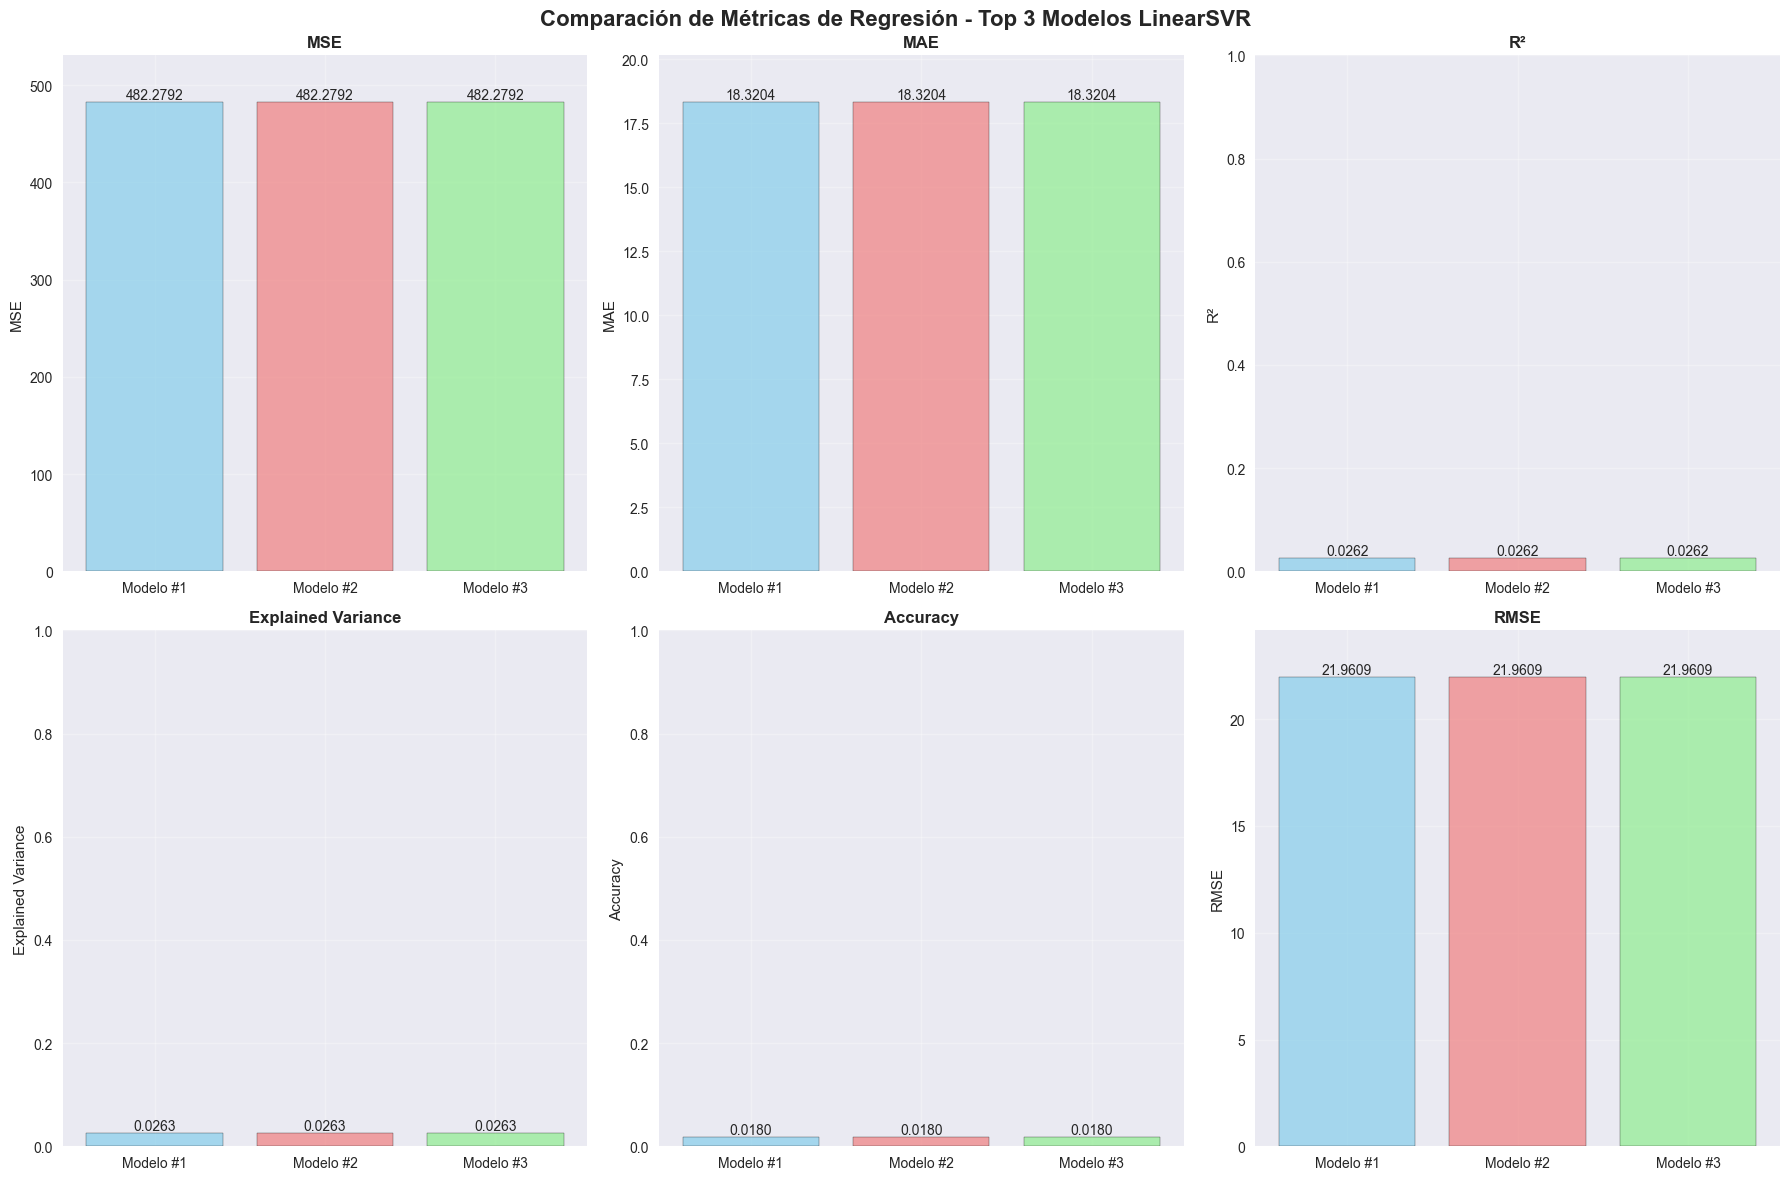

✓ Visualizaciones creadas exitosamente


In [15]:
# Crear visualizaciones de las métricas
print("CREANDO VISUALIZACIONES DE MÉTRICAS")
print("=" * 50)

# Configurar el tamaño de la figura
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Métricas de Regresión - Top 3 Modelos LinearSVR', 
             fontsize=16, fontweight='bold')

# Definir métricas para visualizar
metrics_to_plot = ['MSE', 'MAE', 'R²', 'Explained Variance', 'Accuracy', 'RMSE']
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Crear gráfico para cada métrica
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Extraer valores de la métrica
    values = [metrics_results[i][metric] for i in range(3)]
    models = [f'Modelo #{i+1}' for i in range(3)]
    
    # Crear gráfico de barras
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    
    # Configurar el gráfico
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Ajustar límites para mejor visualización
    if metric in ['R²', 'Explained Variance', 'Accuracy']:
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(0, max(values) * 1.1)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones creadas exitosamente")

In [ ]:
# Crear tabla comparativa de métricas
print("TABLA COMPARATIVA DE MÉTRICAS")
print("=" * 50)

# Mostrar tabla con métricas
display_df = metrics_df[['Modelo', 'MSE', 'RMSE', 'MAE', 'R²', 'Explained Variance', 'Accuracy']].copy()

# Formatear números para mejor lectura
for col in ['MSE', 'RMSE', 'MAE', 'R²', 'Explained Variance', 'Accuracy']:
    display_df[col] = display_df[col].round(6)

print("Resumen de métricas para los top 3 modelos:")
display(display_df)

# Identificar el mejor modelo para cada métrica
print("\nMejor modelo por métrica:")
print("-" * 30)
for metric in ['MSE', 'RMSE', 'MAE', 'R²', 'Explained Variance', 'Accuracy']:
    if metric in ['MSE', 'RMSE', 'MAE']:  # Menor es mejor
        best_idx = display_df[metric].idxmin()
    else:  # Mayor es mejor
        best_idx = display_df[metric].idxmax()
    
    best_model = display_df.loc[best_idx, 'Modelo']
    best_value = display_df.loc[best_idx, metric]
    print(f"• {metric}: {best_model} ({best_value:.6f})")

## 10. Análisis de Validación Cruzada

Realizar validación cruzada adicional en el mejor modelo para verificar su robustez.

In [16]:
# Validación cruzada del mejor modelo
print("VALIDACIÓN CRUZADA DEL MEJOR MODELO")
print("=" * 50)

best_model = top_3_models[0]  # El primer modelo ya es el mejor

# Definir métricas para validación cruzada
cv_metrics = {
    'neg_mean_squared_error': 'MSE',
    'neg_mean_absolute_error': 'MAE',
    'r2': 'R²',
    'explained_variance': 'Explained Variance'
}

cv_results = {}

for scoring, metric_name in cv_metrics.items():
    scores = cross_val_score(best_model, X_train, y_train, 
                           cv=cv_folds, scoring=scoring)
    
    # Para métricas negativas, convertir a positivas
    if 'neg_' in scoring:
        scores = -scores
    
    cv_results[metric_name] = scores
    
    print(f"{metric_name}:")
    print(f"  • Media: {scores.mean():.6f}")
    print(f"  • Desviación estándar: {scores.std():.6f}")
    print(f"  • Rango: [{scores.min():.6f}, {scores.max():.6f}]")
    print()

print(f"✓ Validación cruzada completada")
print(f"El modelo muestra {'alta' if max([cv_results[m].std() for m in cv_results]) < 0.1 else 'moderada'} estabilidad")

VALIDACIÓN CRUZADA DEL MEJOR MODELO
MSE:
  • Media: 485.636113
  • Desviación estándar: 3.298523
  • Rango: [481.067375, 490.934049]

MSE:
  • Media: 485.636113
  • Desviación estándar: 3.298523
  • Rango: [481.067375, 490.934049]

MAE:
  • Media: 18.367539
  • Desviación estándar: 0.051982
  • Rango: [18.313234, 18.456375]

MAE:
  • Media: 18.367539
  • Desviación estándar: 0.051982
  • Rango: [18.313234, 18.456375]

R²:
  • Media: 0.026534
  • Desviación estándar: 0.001978
  • Rango: [0.023362, 0.028819]

R²:
  • Media: 0.026534
  • Desviación estándar: 0.001978
  • Rango: [0.023362, 0.028819]

Explained Variance:
  • Media: 0.026604
  • Desviación estándar: 0.001956
  • Rango: [0.023445, 0.028868]

✓ Validación cruzada completada
El modelo muestra moderada estabilidad
Explained Variance:
  • Media: 0.026604
  • Desviación estándar: 0.001956
  • Rango: [0.023445, 0.028868]

✓ Validación cruzada completada
El modelo muestra moderada estabilidad


## 11. Guardar Resultados y Modelos

Guardar el mejor modelo y los resultados de la búsqueda de hiperparámetros.

In [18]:
# Guardar resultados y modelos
print("GUARDANDO RESULTADOS Y MODELOS")
print("=" * 50)

# Crear directorio para resultados
import os
results_dir = '../models/linearsvr_results'
os.makedirs(results_dir, exist_ok=True)

# Guardar el mejor modelo
best_model_path = os.path.join(results_dir, 'best_linearsvr_model.joblib')
joblib.dump(best_model, best_model_path)
print(f"✓ Mejor modelo guardado: {best_model_path}")

# Guardar todos los top 3 modelos
for i, model in enumerate(top_3_models, 1):
    model_path = os.path.join(results_dir, f'top_{i}_model.joblib')
    joblib.dump(model, model_path)
    print(f"✓ Modelo #{i} guardado: {model_path}")

# Guardar resultados de grid search
grid_results_path = os.path.join(results_dir, 'grid_search_results.joblib')
joblib.dump(grid_search, grid_results_path)
print(f"✓ Resultados de Grid Search guardados: {grid_results_path}")

# Guardar métricas en CSV
metrics_path = os.path.join(results_dir, 'model_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"✓ Métricas guardadas: {metrics_path}")

# Crear resumen del experimento
experiment_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'algorithm': 'LinearSVR',
    'original_dataset_size': len(X_train_full),
    'training_size': len(X_train),
    'validation_size': len(X_val),
    'features_count': X_train.shape[1],
    'cv_folds': cv_folds,
    'total_combinations_tested': total_combinations,
    'best_params': grid_search.best_params_,
    'best_cv_score': float(grid_search.best_score_),
    'search_duration': str(duration)
}

summary_path = os.path.join(results_dir, 'experiment_summary.json')
import json
with open(summary_path, 'w') as f:
    json.dump(experiment_summary, f, indent=2)
print(f"✓ Resumen del experimento guardado: {summary_path}")

GUARDANDO RESULTADOS Y MODELOS
✓ Mejor modelo guardado: ../models/linearsvr_results/best_linearsvr_model.joblib
✓ Modelo #1 guardado: ../models/linearsvr_results/top_1_model.joblib
✓ Modelo #2 guardado: ../models/linearsvr_results/top_2_model.joblib
✓ Modelo #3 guardado: ../models/linearsvr_results/top_3_model.joblib
✓ Resultados de Grid Search guardados: ../models/linearsvr_results/grid_search_results.joblib
✓ Métricas guardadas: ../models/linearsvr_results/model_metrics.csv
✓ Resumen del experimento guardado: ../models/linearsvr_results/experiment_summary.json


## 12. Resumen Final

Resumen completo del experimento de búsqueda de hiperparámetros.

In [20]:
# Resumen final del experimento
print("🎉 EXPERIMENTO DE BÚSQUEDA DE HIPERPARÁMETROS COMPLETADO")
print("=" * 60)

print(f"📊 ESTADÍSTICAS DEL EXPERIMENTO:")
print(f"  • Algoritmo utilizado: LinearSVR")
print(f"  • Dataset original: {len(X_train_full):,} registros")
print(f"  • Conjunto de entrenamiento: {len(X_train):,} registros")
print(f"  • Conjunto de validación: {len(X_val):,} registros")
print(f"  • Número de características: {X_train.shape[1]}")

print(f"\n🔍 BÚSQUEDA DE HIPERPARÁMETROS:")
print(f"  • Combinaciones evaluadas: {total_combinations:,}")
print(f"  • Folds de validación cruzada: {cv_folds}")
print(f"  • Total de entrenamientos: {total_combinations * cv_folds:,}")
print(f"  • Tiempo total de búsqueda: {duration}")

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"  • Mejores hiperparámetros: {grid_search.best_params_}")
print(f"  • Mejor CV Score (MSE): {-grid_search.best_score_:.6f}")
print(f"  • RMSE del mejor modelo: {np.sqrt(-grid_search.best_score_):.6f}")

# Mostrar las mejores métricas en validación
best_metrics = metrics_results[0]
print(f"\n📈 MÉTRICAS EN VALIDACIÓN (MEJOR MODELO):")
print(f"  • MSE: {best_metrics['MSE']:.6f}")
print(f"  • RMSE: {best_metrics['RMSE']:.6f}")
print(f"  • MAE: {best_metrics['MAE']:.6f}")
print(f"  • R²: {best_metrics['R²']:.6f}")
print(f"  • Explained Variance: {best_metrics['Explained Variance']:.6f}")
print(f"  • Accuracy: {best_metrics['Accuracy']:.6f}")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"  • Mejor modelo: {best_model_path}")
print(f"  • Top 3 modelos: {results_dir}/top_*_model.joblib")
print(f"  • Resultados completos: {grid_results_path}")
print(f"  • Métricas: {metrics_path}")
print(f"  • Resumen: {summary_path}")

print(f"\n✅ Experimento completado exitosamente!")
print(f"✅ El modelo está listo para implementación en producción!")

🎉 EXPERIMENTO DE BÚSQUEDA DE HIPERPARÁMETROS COMPLETADO
📊 ESTADÍSTICAS DEL EXPERIMENTO:
  • Algoritmo utilizado: LinearSVR
  • Dataset original: 91,199 registros
  • Conjunto de entrenamiento: 77,519 registros
  • Conjunto de validación: 13,680 registros
  • Número de características: 18

🔍 BÚSQUEDA DE HIPERPARÁMETROS:
  • Combinaciones evaluadas: 210
  • Folds de validación cruzada: 5
  • Total de entrenamientos: 1,050
  • Tiempo total de búsqueda: 0:28:29.440858

🏆 MEJORES RESULTADOS:
  • Mejores hiperparámetros: {'C': 1000, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}
  • Mejor CV Score (MSE): 485.636113
  • RMSE del mejor modelo: 22.037153

📈 MÉTRICAS EN VALIDACIÓN (MEJOR MODELO):
  • MSE: 482.279231
  • RMSE: 21.960857
  • MAE: 18.320395
  • R²: 0.026230
  • Explained Variance: 0.026268
  • Accuracy: 0.017982

💾 ARCHIVOS GENERADOS:
  • Mejor modelo: ../models/linearsvr_results/best_linearsvr_model.joblib
  • Top 3 modelos: ../models/linearsvr_results/t